# Data Transformation

In previous notebooks we learned how to use marks and visual encodings to represent individual data records. Here we will explore methods for *transforming* data, including the use of aggregates to summarize multiple records. Data transformation is an integral part of visualization: choosing the  variables to show and their level of detail is just as important as choosing appropriate visual encodings. After all, it doesn't matter how well chosen your visual encodings are if you are showing the wrong information!

As you work through this module, we recommend that you open the [Altair Data Transformations documentation](https://altair-viz.github.io/user_guide/transform.html) in another tab. It will be a useful resource if at any point you'd like more details or want to see what other transformations are available.

_This notebook is part of the [data visualization curriculum](https://github.com/uwdata/visualization-curriculum)._

In [1]:
import pandas as pd
import altair as alt

## The Movies Dataset

We will be working with a table of data about motion pictures, taken from the [vega-datasets](https://vega.github.io/vega-datasets/) collection. The data includes variables such as the film name, director, genre, release date, ratings, and gross revenues. However, _be careful when working with this data_: the films are from unevenly sampled years, using data combined from multiple sources. If you dig in you will find issues with missing values and even some subtle errors! Nevertheless, the data should prove interesting to explore...

Let's retrieve the URL for the JSON data file from the vega_datasets package, and then read the data into a Pandas data frame so that we can inspect its contents.

In [2]:
from vega_datasets import data as vega_data
movies_url = vega_data.movies.url
movies = pd.read_json(movies_url)

How many rows (records) and columns (fields) are in the movies dataset?

In [3]:
movies.shape

(3201, 16)

Now let's peek at the first 5 rows of the table to get a sense of the fields and data types...

In [4]:
movies.head(5)

,Creative_Type,Director,Distributor,IMDB_Rating,IMDB_Votes,MPAA_Rating,Major_Genre,Production_Budget,Release_Date,Rotten_Tomatoes_Rating,Running_Time_min,Source,Title,US_DVD_Sales,US_Gross,Worldwide_Gross
0,None,None,Gramercy,6.1,1071.0,R,None,8000000.0,12-Jun-98,NaN,NaN,None,The Land Girls,NaN,146083.0,146083.0
1,None,None,Strand,6.9,207.0,R,Drama,300000.0,7-Aug-98,NaN,NaN,None,"First Love, Last Rites",NaN,10876.0,10876.0
2,None,None,Lionsgate,6.8,865.0,None,Comedy,250000.0,28-Aug-98,NaN,NaN,None,I Married a Strange Person,NaN,203134.0,203134.0
3,None,None,Fine Line,NaN,NaN,None,Comedy,300000.0,11-Sep-98,13.0,NaN,None,Let's Talk About Sex,NaN,373615.0,373615.0
4,Contemporary Fiction,None,Trimark,3.4,165.0,R,Drama,1000000.0,9-Oct-98,62.0,NaN,Original Screenplay,Slam,NaN,1009819.0,1087521.0


## Histograms

We'll start our transformation tour by _binning_ data into discrete groups and _counting_ records to summarize those groups. The resulting plots are known as [_histograms_](https://en.wikipedia.org/wiki/Histogram).

Let's first look at unaggregated data: a scatter plot showing movie ratings from Rotten Tomatoes versus ratings from IMDB users. We'll provide data to Altair by passing the movies data URL to the `Chart` method. (We could also pass the Pandas data frame directly to get the same result.) We can then encode the Rotten Tomatoes and IMDB ratings fields using the `x` and `y` channels:

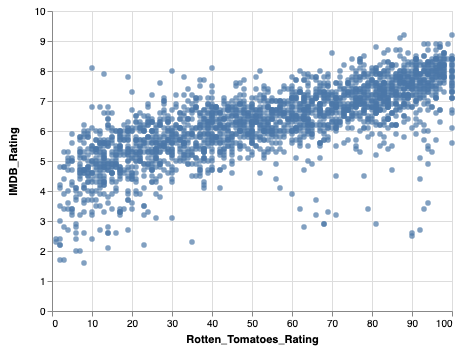

In [5]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q'),
    alt.Y('IMDB_Rating:Q')
)

To summarize this data, we can *bin* a data field to group numeric values into discrete groups. Here we bin along the x-axis by adding `bin=True` to the `x` encoding channel. The result is a set of ten bins of equal step size, each corresponding to a span of ten ratings points.

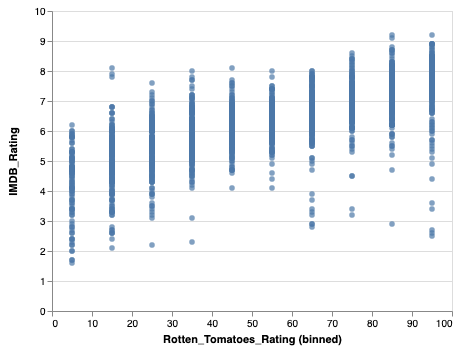

In [6]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q', bin=True),
    alt.Y('IMDB_Rating:Q')
)

Setting `bin=True` uses default binning settings, but we can exercise more control if desired. Let's instead set the maximum bin count (`maxbins`) to 20, which has the effect of doubling the number of bins. Now each bin corresponds to a span of five ratings points.

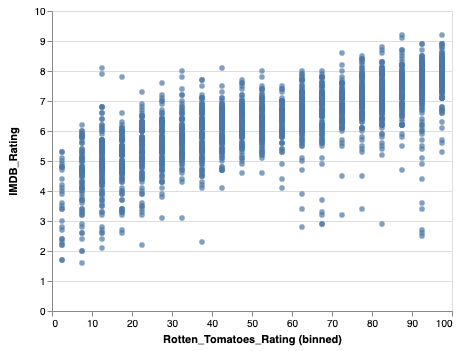

In [7]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Y('IMDB_Rating:Q')
)

With the data binned, let's now summarize the distribution of Rotten Tomatoes ratings. We will drop the IMDB ratings for now and instead use the `y` encoding channel to show an aggregate `count` of records, so that the vertical position of each point indicates the number of movies per Rotten Tomatoes rating bin.

As the `count` aggregate counts the number of total records in each bin regardless of the field values, we do not need to include a field name in the `y` encoding.

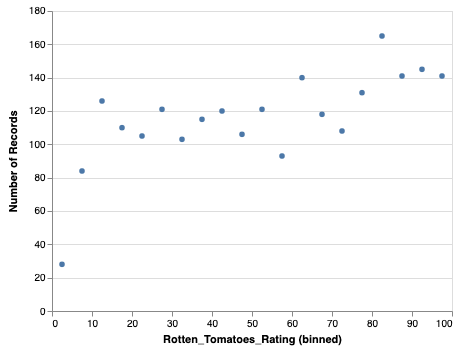

In [8]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Y('count()')
)

To arrive at a standard histogram, let's change the mark type from `circle` to `bar`:

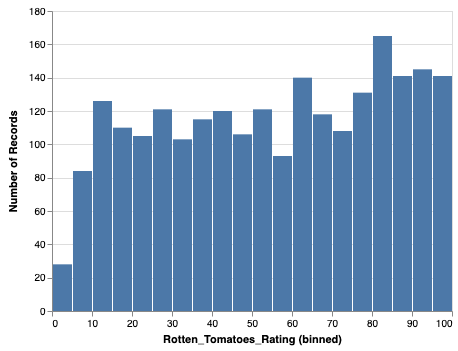

In [9]:
alt.Chart(movies_url).mark_bar().encode(
    alt.X('Rotten_Tomatoes_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Y('count()')
)

_We can now examine the distribution of ratings more clearly: we can see fewer movies on the negative end, and a bit more movies on the high end, but a generally uniform distribution overall. Rotten Tomatoes ratings are determined by taking "thumbs up" and "thumbs down" judgments from film critics and calculating the percentage of positive reviews. It appears this approach does a good job of utilizing the full range of rating values._

Similarly, we can create a histogram for IMDB ratings by changing the field in the `x` encoding channel:

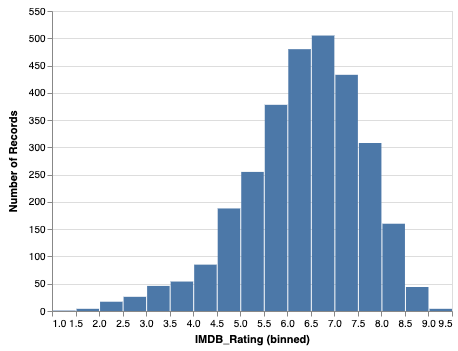

In [10]:
alt.Chart(movies_url).mark_bar().encode(
    alt.X('IMDB_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Y('count()')
)

_In contrast to the more uniform distribution we saw before, IMDB ratings exhibit a bell-shaped (though [negatively skewed](https://en.wikipedia.org/wiki/Skewness)) distribution. IMDB ratings are formed by averaging scores (ranging from 1 to 10) provided by the site's users. We can see that this form of measurement leads to a different shape than the Rotten Tomatoes ratings. We can also see that the mode of the distribution is between 6.5 and 7: people generally enjoy watching movies, potentially explaining the positive bias!_

Now let's turn back to our scatter plot of Rotten Tomatoes and IMDB ratings. Here's what happens if we bin *both* axes of our original plot.

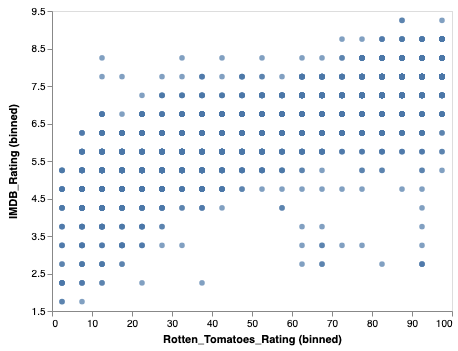

In [11]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Y('IMDB_Rating:Q', bin=alt.BinParams(maxbins=20)),
)

Detail is lost due to *overplotting*, with many points drawn directly on top of each other.

To form a two-dimensional histogram we can add a `count` aggregate as before. As both the `x` and `y` encoding channels are already taken, we must use a different encoding channel to convey the counts. Here is the result of using circular area by adding a *size* encoding channel.

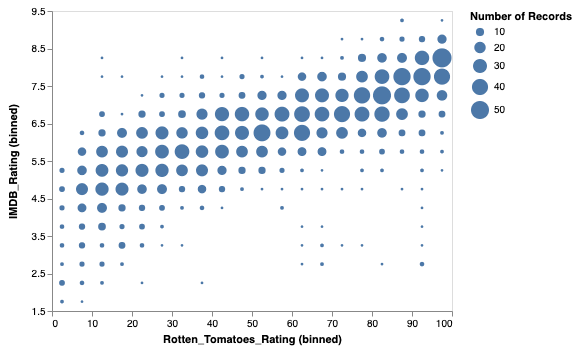

In [12]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Y('IMDB_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Size('count()')
)

Alternatively, we can encode counts using the `color` channel and change the mark type to `bar`. The result is a two-dimensional histogram in the form of a [*heatmap*](https://en.wikipedia.org/wiki/Heat_map).

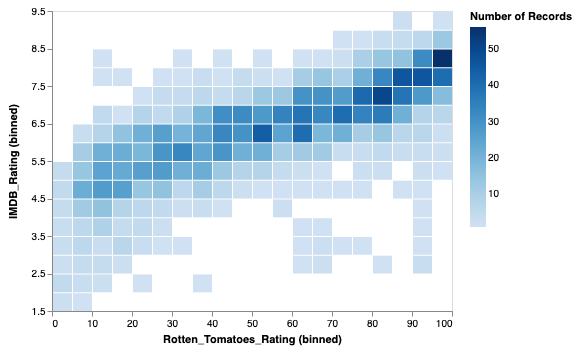

In [13]:
alt.Chart(movies_url).mark_bar().encode(
    alt.X('Rotten_Tomatoes_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Y('IMDB_Rating:Q', bin=alt.BinParams(maxbins=20)),
    alt.Color('count()')
)

Compare the *size* and *color*-based 2D histograms above. Which encoding do you think should be preferred? Why? In which plot can you more precisely compare the magnitude of individual values? In which plot can you more accurately see the overall density of ratings?

## Aggregation

Counts are just one type of aggregate. We might also calculate summaries using measures such as the `average`, `median`, `min`, or `max`. The Altair documentation includes the [full set of available aggregation functions](https://altair-viz.github.io/user_guide/encoding.html#encoding-aggregates).

Let's look at some examples!

### Averages and Sorting

_Do different genres of films receive consistently different ratings from critics?_ As a first step towards answering this question, we might examine the [*average* (a.k.a. the *arithmetic mean*)](https://en.wikipedia.org/wiki/Arithmetic_mean) rating for each genre of movie.

Let's visualize genre along the `y` axis and plot `average` Rotten Tomatoes ratings along the `x` axis.

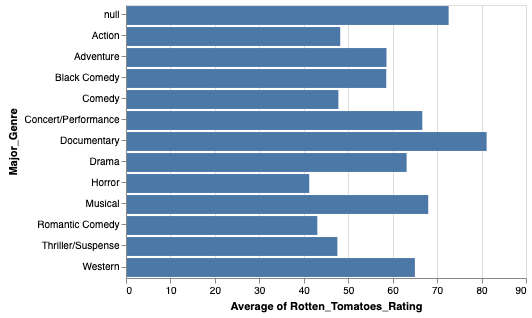

In [14]:
alt.Chart(movies_url).mark_bar().encode(
    alt.X('average(Rotten_Tomatoes_Rating):Q'),
    alt.Y('Major_Genre:N')
)

_There does appear to be some interesting variation, but looking at the data as an alphabetical list is not very helpful for ranking critical reactions to the genres._

For a tidier picture, let's sort the genres in descending order of average rating. To do so, we will add a `sort` parameter to the `y` encoding channel, stating that we wish to sort by the *average* (`op`, the aggregate operation) Rotten Tomatoes rating (the `field`) in descending `order`.

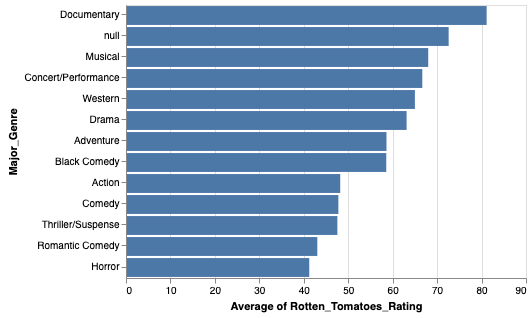

In [15]:
alt.Chart(movies_url).mark_bar().encode(
    alt.X('average(Rotten_Tomatoes_Rating):Q'),
    alt.Y('Major_Genre:N', sort=alt.EncodingSortField(
        op='average', field='Rotten_Tomatoes_Rating', order='descending')
    )
)

_The sorted plot suggests that critics think highly of documentaries, musicals, westerns, and dramas, but look down upon romantic comedies and horror films... and who doesn't love `null` movies!?_

### Medians and the Inter-Quartile Range

While averages are a common way to summarize data, they can sometimes mislead. For example, very large or very small values ([*outliers*](https://en.wikipedia.org/wiki/Outlier)) might skew the average. To be safe, we can compare the genres according to the [*median*](https://en.wikipedia.org/wiki/Median) ratings as well.

The median is a point that splits the data evenly, such that half of the values are less than the median and the other half are greater. The median is less sensitive to outliers and so is referred to as a [*robust* statistic](https://en.wikipedia.org/wiki/Robust_statistics). For example, arbitrarily increasing the largest rating value will not cause the median to change.

Let's update our plot to use a `median` aggregate and sort by those values:

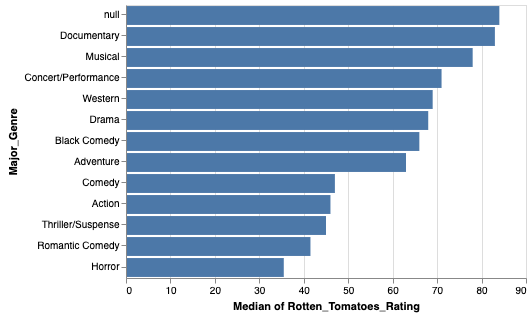

In [16]:
alt.Chart(movies_url).mark_bar().encode(
    alt.X('median(Rotten_Tomatoes_Rating):Q'),
    alt.Y('Major_Genre:N', sort=alt.EncodingSortField(
        op='median', field='Rotten_Tomatoes_Rating', order='descending')
    )
)

_We can see that some of the genres with similar averages have swapped places (films of unknown genre, or `null`, are now rated highest!), but the overall groups have stayed stable. Horror films continue to get little love from professional film critics._

It's a good idea to stay skeptical when viewing aggregate statistics. So far we've only looked at *point estimates*. We have not examined how ratings vary within a genre.

Let's visualize the variation among the ratings to add some nuance to our rankings. Here we will encode the [*inter-quartile range* (IQR)](https://en.wikipedia.org/wiki/Interquartile_range) for each genre. The IQR is the range in which the middle half of data values reside. A [*quartile*](https://en.wikipedia.org/wiki/Quartile) contains 25% of the data values. The inter-quartile range consists of the two middle quartiles, and so contains the middle 50%. 

To visualize ranges, we can use the `x` and `x2` encoding channels to indicate the starting and ending points. We use the aggregate functions `q1` (the lower quartile boundary) and `q3` (the upper quartile boundary) to provide the inter-quartile range. (In case you are wondering, *q2* would be the median.)

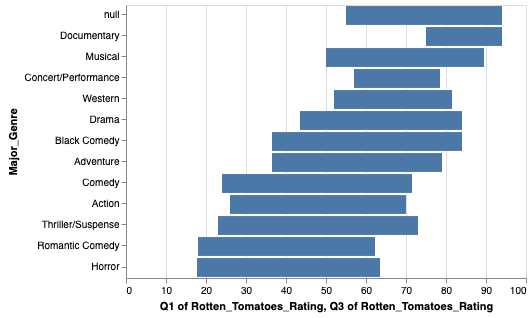

In [17]:
alt.Chart(movies_url).mark_bar().encode(
    alt.X('q1(Rotten_Tomatoes_Rating):Q'),
    alt.X2('q3(Rotten_Tomatoes_Rating):Q'),
    alt.Y('Major_Genre:N', sort=alt.EncodingSortField(
        op='median', field='Rotten_Tomatoes_Rating', order='descending')
    )
)

### Time Units

_Now let's ask a completely different question: do box office returns vary by season?_

To get an initial answer, let's plot the median U.S. gross revenue by month.

To make this chart, use the `timeUnit` transform to map release dates to the `month` of the year. The result is similar to binning, but using meaningful time intervals. Other valid time units include `year`, `quarter`, `date` (numeric day in month), `day` (day of the week), and `hours`, as well as compound units such as `yearmonth` or `hoursminutes`. See the Altair documentation for a [complete list of time units](https://altair-viz.github.io/user_guide/transform.html#timeunit-transform).

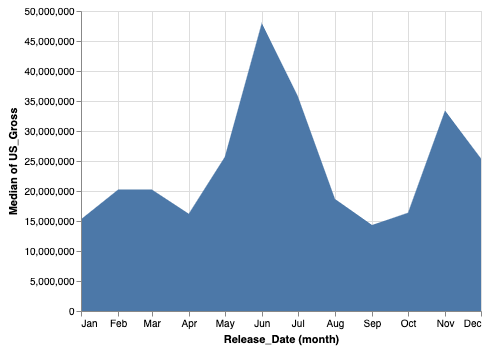

In [18]:
alt.Chart(movies_url).mark_area().encode(
    alt.X('month(Release_Date):T'),
    alt.Y('median(US_Gross):Q')
)

_Looking at the resulting plot, median movie sales in the U.S. appear to spike around the summer blockbuster season and the end of year holiday period. Of course, people around the world (not just the U.S.) go out to the movies. Does a similar pattern arise for worldwide gross revenue?_

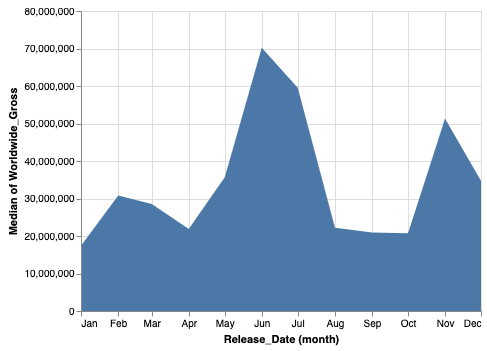

In [19]:
alt.Chart(movies_url).mark_area().encode(
    alt.X('month(Release_Date):T'),
    alt.Y('median(Worldwide_Gross):Q')
)

_Yes!_

## Advanced Data Transformation

The examples above all use transformations (*bin*, *timeUnit*, *aggregate*, *sort*) that are defined relative to an encoding channel. However, at times you may want to apply a chain of multiple transformations prior to visualization, or use transformations that don't integrate into encoding definitions. For such cases, Altair and Vega-Lite support data transformations defined separately from encodings. These transformations are applied to the data *before* any encodings are considered.

We *could* also perform transformations using Pandas directly, and then visualize the result. However, using the built-in transforms allows our visualizations to be published more easily in other contexts; for example, exporting the Vega-Lite JSON to use in a stand-alone web interface. Let's look at the built-in transforms supported by Altair, such as `calculate`, `filter`, `aggregate`, and `window`.

### Calculate

_Think back to our comparison of U.S. gross and worldwide gross. Doesn't worldwide revenue include the U.S.? (Indeed it does.) How might we get a better sense of trends outside the U.S.?_

With the `calculate` transform we can derive new fields. Here we want to subtract U.S. gross from worldwide gross. The `calculate` transform takes a [Vega expression string](https://vega.github.io/vega/docs/expressions/) to define a formula over a single record. Vega expressions use JavaScript syntax. The `datum.` prefix accesses a field value on the input record.

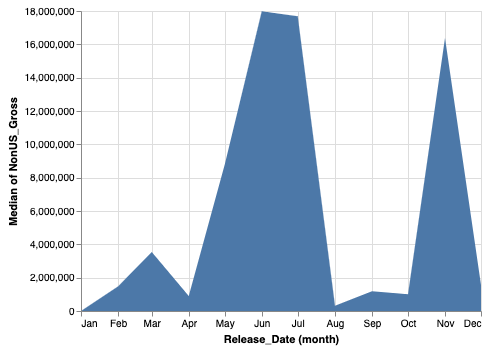

In [20]:
alt.Chart(movies).mark_area().transform_calculate(
    NonUS_Gross='datum.Worldwide_Gross - datum.US_Gross'
).encode(
    alt.X('month(Release_Date):T'),
    alt.Y('median(NonUS_Gross):Q')
)

_We can see that seasonal trends hold outside the U.S., but with a more pronounced decline in the non-peak months._

### Filter

The *filter* transform creates a new table with a subset of the original data, removing rows that fail to meet a provided [*predicate*](https://en.wikipedia.org/wiki/Predicate_%28mathematical_logic%29) test. Similar to the *calculate* transform, filter predicates are expressed using the [Vega expression language](https://vega.github.io/vega/docs/expressions/).

Below we add a filter to limit our initial scatter plot of IMDB vs. Rotten Tomatoes ratings to only films in the major genre of "Romantic Comedy".

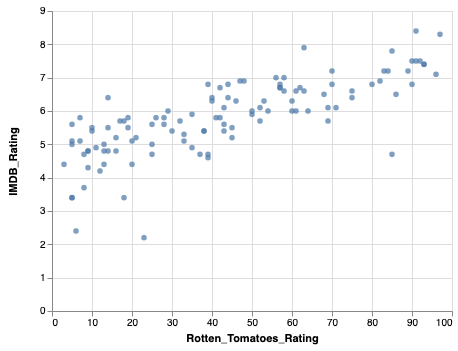

In [21]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q'),
    alt.Y('IMDB_Rating:Q')
).transform_filter('datum.Major_Genre == "Romantic Comedy"')

_How does the plot change if we filter to view other genres? Edit the filter expression to find out._

Now let's filter to look at films released before 1970.

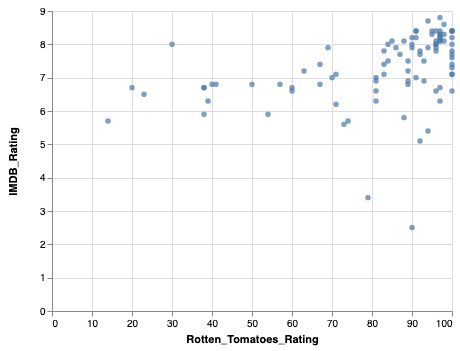

In [22]:
alt.Chart(movies_url).mark_circle().encode(
    alt.X('Rotten_Tomatoes_Rating:Q'),
    alt.Y('IMDB_Rating:Q')
).transform_filter('year(datum.Release_Date) < 1970')

_They seem to score unusually high! Are older films simply better, or is there a [selection bias](https://en.wikipedia.org/wiki/Selection%5Fbias) towards more highly-rated older films in this dataset?_

### Aggregate

We have already seen `aggregate` transforms such as `count` and `average`  in the context of encoding channels. We can also specify aggregates separately, as a pre-processing step for other transforms (as in the `window` transform examples below). The output of an `aggregate` transform is a new data table with records that contain both the `groupby` fields and the computed `aggregate` measures.

Let's recreate our plot of average ratings by genre, but this time using a separate `aggregate` transform. The output table from the aggregate transform contains 13 rows, one for each genre.

To order the `y` axis we must include a required aggregate operation in our sorting instructions. Here we use the `max` operator, which works fine because there is only one output record per genre. We could similarly use the `min` operator and end up with the same plot.

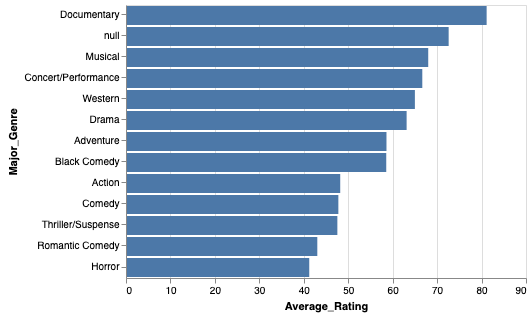

In [23]:
alt.Chart(movies_url).mark_bar().transform_aggregate(
    groupby=['Major_Genre'],
    Average_Rating='average(Rotten_Tomatoes_Rating)'
).encode(
    alt.X('Average_Rating:Q'),
    alt.Y('Major_Genre:N', sort=alt.EncodingSortField(
        op='max', field='Average_Rating', order='descending'
      )
    )
)

### Window

The `window` transform performs calculations over sorted groups of data records. Window transforms are quite powerful, supporting tasks such as ranking, lead/lag analysis, cumulative totals, and running sums or averages. Values calculated by a `window` transform are written back to the input data table as new fields. Window operations include the aggregate operations we've seen earlier, as well as specialized operations such as `rank`, `row_number`, `lead`, and `lag`. The Vega-Lite documentation lists [all valid window operations](https://vega.github.io/vega-lite/docs/window.html#ops).

One use case for a `window` transform is to calculate top-k lists. Let's plot the top 20 directors in terms of total worldwide gross.

We first use a `filter` transform to remove records for which we don't know the director. Otherwise, the director `null` would dominate the list! We then apply an `aggregate` to sum up the worldwide gross for all films, grouped by director. At this point we could plot a sorted bar chart, but we'd end up with hundreds and hundreds of directors. How can we limit the display to the top 20?

The `window` transform allows us to determine the top directors by calculating their rank order. Within our `window` transform definition we can `sort` by gross and use the `rank` operation to calculate rank scores according to that sort order. We can then add a subsequent `filter` transform to limit the data to only records with a rank value less than or equal to 20.

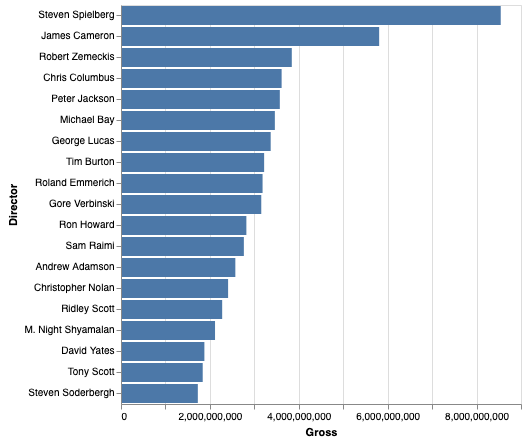

In [24]:
alt.Chart(movies_url).mark_bar().transform_filter(
    'datum.Director != null'
).transform_aggregate(
    Gross='sum(Worldwide_Gross)',
    groupby=['Director']
).transform_window(
    Rank='rank()',
    sort=[alt.SortField('Gross', order='descending')]
).transform_filter(
    'datum.Rank < 20'
).encode(
    alt.X('Gross:Q'),
    alt.Y('Director:N', sort=alt.EncodingSortField(
        op='max', field='Gross', order='descending'
    ))
)

_We can see that Steven Spielberg has been quite successful in his career! However, showing sums might favor directors who have had longer careers, and so have made more movies and thus more money. What happens if we change the choice of aggregate operation? Who is the most successful director in terms of  `average` or `median` gross per film? Modify the aggregate transform above!_

Earlier in this notebook we looked at histograms, which approximate the [*probability density function*](https://en.wikipedia.org/wiki/Probability_density_function) of a set of values. A complementary approach is to look at the [*cumulative distribution*](https://en.wikipedia.org/wiki/Cumulative_distribution_function). For example, think of a histogram in which each bin includes not only its own count but also the counts from all previous bins &mdash; the result is a _running total_, with the last bin containing the total number of records. A cumulative chart directly shows us, for a given reference value, how many data values are less than or equal to that reference.

As a concrete example, let's look at the cumulative distribution of films by running time (in minutes). Only a subset of records actually include running time information, so we first `filter` down to the subset of films for which we have running times. Next, we apply an `aggregate` to count the number of films per duration (implicitly using "bins" of 1 minute each). We then use a `window` transform to compute a running total of counts across bins, sorted by increasing running time.

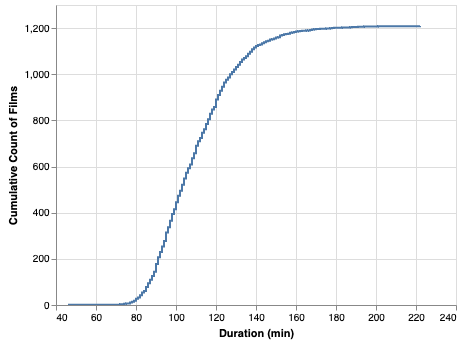

In [25]:
alt.Chart(movies_url).mark_line(interpolate='step-before').transform_filter(
    'datum.Running_Time_min != null'
).transform_aggregate(
    groupby=['Running_Time_min'],
    Count='count()',
).transform_window(
    Cumulative_Sum='sum(Count)',
    sort=[alt.SortField('Running_Time_min', order='ascending')]
).encode(
    alt.X('Running_Time_min:Q', axis=alt.Axis(title='Duration (min)')),
    alt.Y('Cumulative_Sum:Q', axis=alt.Axis(title='Cumulative Count of Films'))
)

_Let's examine the cumulative distribution of film lengths. We can see that films under 110 minutes make up about half of all the films for which we have running times. We see a steady accumulation of films between 90 minutes and 2 hours, after which the distribution begins to taper off. Though rare, the dataset does contain multiple films more than 3 hours long!_

## Summary

We've only scratched the surface of what data transformations can do! For more details, including all the available transformations and their parameters, see the [Altair data transformation documentation](https://altair-viz.github.io/user_guide/transform.html).

Sometimes you will need to perform significant data transformation to prepare your data _prior_ to using visualization tools. To engage in [_data wrangling_](https://en.wikipedia.org/wiki/Data_wrangling) right here in Python, you can use the [Pandas library](https://pandas.pydata.org/).